# YouTube trending videos

In [46]:
%matplotlib inline
import os
import matplotlib.pyplot as plt
import pandas as pd
from tokenizers import Tokenizer, RE_HTTP
from tqdm.notebook import tqdm
from split import split_csv
import nltk
import re
import string
import math
import json
from pandas.plotting import scatter_matrix

from categories import get_categories_dict

## Etap 1 - Atrybuty tekstowe

### Opis atrybutów

W obu zbiorach danych występują następujące atrybuty:
- **video_id** - identyfikator filmu
- **trending_date** - data pojawienia się w sekcji "trending"
- **title** - tytuł filmu,
- **channel_title** - nazwa kanału,
- **category_id** - identyfikator kategorii w do jakiego należy film,
- **publish_time** - data publikacji filmu,
- **tags** - tagi, którymi został oznaczony film,
- **views** - liczba wyświetleń filmu,
- **likes** - liczba polubień filmu,
- **dislikes** - liczba zaznaczeń "Nie podoba mi się" danego filmu,
- **comment_count** - liczba komentarzy pod filmem,
- **thumbnail_link** - url prowadzący do obrazka filmu,
- **comments_disabled** - zmienna logiczna wskazująca na zabronienie komentowania filmu,
- **ratings_disabled** - zmienna logiczna wskazująca na zabronienie oceniania filmu,
- **video_error_or_removed** - zmienna logiczna wskazująca na błąd w filmie lub jego usunięcie,
- **description** - opis filmu

### Wczytanie danych

Podczas wczytywania danych dodatkowo korygowana jest nazwa kolumny *description*, ponieważ
wykryto w niej dodatkową spację.

In [47]:
gb_videos = pd.read_csv(os.path.join("youtube_data", "GB_videos_5p.csv"), sep=";")
us_videos = pd.read_csv(os.path.join("youtube_data", "US_videos_5p.csv"), sep=";")
videos = pd.concat([gb_videos, us_videos])
videos = videos.rename(columns={"description ":"description"})
videos.head(10)

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description
0,Jw1Y-zhQURU,17.14.11,John Lewis Christmas Ad 2017 - #MozTheMonster,John Lewis,NaN,2017-11-10T07:38:29.000Z,"christmas|""john lewis christmas""|""john lewis""|...",7224515,55681,10247,9479,https://i.ytimg.com/vi/Jw1Y-zhQURU/default.jpg,False,False,False,Click here to continue the story and make your...
1,3s1rvMFUweQ,17.14.11,Taylor Swift: …Ready for It? (Live) - SNL,Saturday Night Live,NaN,2017-11-12T06:24:44.000Z,"SNL|""Saturday Night Live""|""SNL Season 43""|""Epi...",1053632,25561,2294,2757,https://i.ytimg.com/vi/3s1rvMFUweQ/default.jpg,False,False,False,Musical guest Taylor Swift performs …Ready for...
2,n1WpP7iowLc,17.14.11,Eminem - Walk On Water (Audio) ft. Beyoncé,EminemVEVO,NaN,2017-11-10T17:00:03.000Z,"Eminem|""Walk""|""On""|""Water""|""Aftermath/Shady/In...",17158579,787420,43420,125882,https://i.ytimg.com/vi/n1WpP7iowLc/default.jpg,False,False,False,Eminem's new track Walk on Water ft. Beyoncé i...
3,PUTEiSjKwJU,17.14.11,Goals from Salford City vs Class of 92 and Fri...,Salford City Football Club,NaN,2017-11-13T02:30:38.000Z,"Salford City FC|""Salford City""|""Salford""|""Clas...",27833,193,12,37,https://i.ytimg.com/vi/PUTEiSjKwJU/default.jpg,False,False,False,Salford drew 4-4 against the Class of 92 and F...
4,rHwDegptbI4,17.14.11,Dashcam captures truck's near miss with child ...,Cute Girl Videos,NaN,2017-11-13T01:45:13.000Z,[none],9815,30,2,30,https://i.ytimg.com/vi/rHwDegptbI4/default.jpg,False,False,False,Dashcam captures truck's near miss with child ...
5,AumaWl0TNBo,17.14.11,How My Relationship Started!,PointlessBlogVlogs,NaN,2017-11-11T17:00:00.000Z,"pointlessblog|""pointlessblogtv""|""pointlessblog...",1182775,52708,1431,2333,https://i.ytimg.com/vi/AumaWl0TNBo/default.jpg,False,False,False,► HOW MY RELATIONSHIP STARTED!\n► PB Merch • h...
6,2Vv-BfVoq4g,17.14.11,Ed Sheeran - Perfect (Official Music Video),Ed Sheeran,NaN,2017-11-09T11:04:14.000Z,"edsheeran|""ed sheeran""|""acoustic""|""live""|""cove...",33523622,1634124,21082,85067,https://i.ytimg.com/vi/2Vv-BfVoq4g/default.jpg,False,False,False,🎧: https://ad.gt/yt-perfect\n💰: https://atlant...
7,#NAZWA?,17.14.11,CHRISTMAS HAS GONE TO MY HEAD,MoreZoella,NaN,2017-11-10T19:19:43.000Z,"zoe sugg|""zoella""|""zoe""|""vlog""|""vlogging""|""vlo...",1164201,57309,749,624,https://i.ytimg.com/vi/-N5eucPMTTc/default.jpg,False,False,False,CHRISTMAS HAS GONE TO MY HEAD\nPrevious Vlog: ...
8,LMCuKltaY3M,17.14.11,Elbow - Golden Slumbers (John Lewis Advert 2017),ElbowVEVO,NaN,2017-11-10T08:00:01.000Z,"Elbow|""Golden""|""Slumbers""|""Polydor""|""Alternative""",154494,2163,147,211,https://i.ytimg.com/vi/LMCuKltaY3M/default.jpg,False,False,False,"“Golden Slumbers”, originally by The Beatles, ..."
9,9t9u_yPEidY,17.14.11,"Jennifer Lopez - Amor, Amor, Amor (Official Vi...",JenniferLopezVEVO,NaN,2017-11-10T15:00:00.000Z,"Jennifer Lopez ft. Wisin|""Jennifer Lopez ft. W...",9548677,190084,15015,11473,https://i.ytimg.com/vi/9t9u_yPEidY/default.jpg,False,False,False,"Jennifer Lopez ft. Wisin - Amor, Amor, Amor (O..."


### Tytuły kanałów - *channel_title*

Pierwszym atrybutem, który został poddany analizie były tytuły kanałów, na których
zostały opublikowane filmy.

Poniższy kod sprawdza ewentualne powtórzenia w zbiorze danych i wyświetla podstawowe
statystyki zliczania nazw kanałów.

In [48]:
channel_titles = videos["channel_title"]
unique_channel_titles = videos["channel_title"].value_counts()
unique_channel_titles = unique_channel_titles.rename_axis("channel_title").reset_index(name="count")
unique_channel_titles.describe()

,count
count,3099.000000
mean,25.771217
std,41.908339
min,1.000000
25%,5.000000
50%,11.000000
75%,27.000000
max,405.000000


Można zauważyć, że jedna z nazw występuje aż 405 razy.

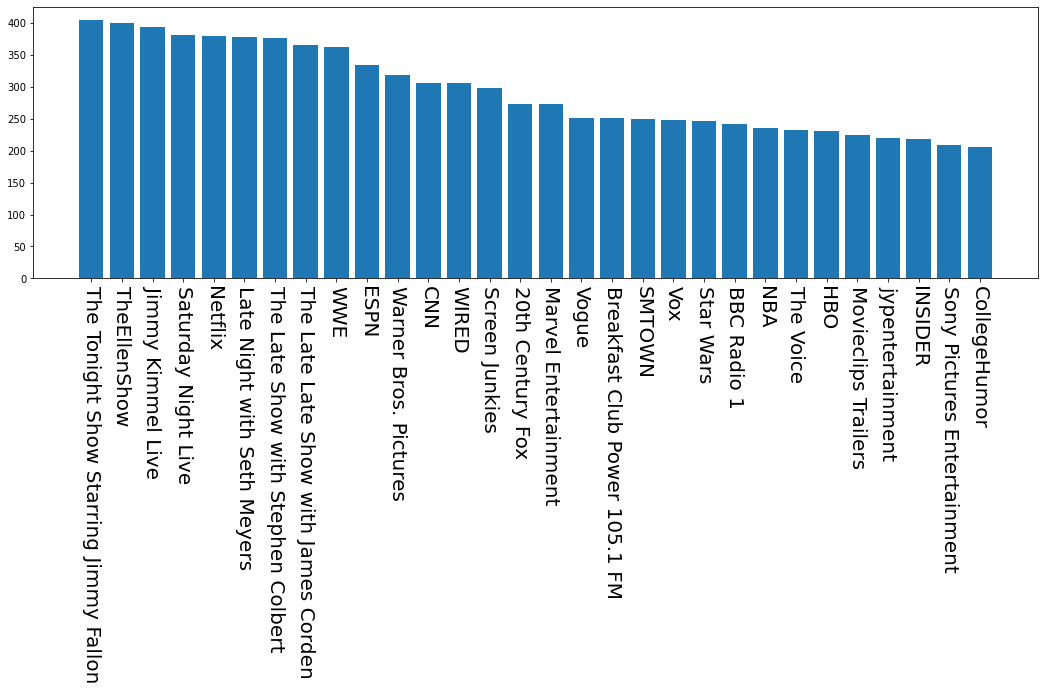

In [49]:
plt.subplots(figsize=(18,5))
plt.bar(unique_channel_titles.head(30)["channel_title"], unique_channel_titles.head(30)["count"])
plt.xticks(rotation=270, fontsize=20)
plt.show()

Na wykresie przedstawione są 30 najczęściej występujących nazw kanałów.
Wśród nich można zauważyć znane nazwy jak **Netflix**, **20th Century Fox**, **HBO**,
**Star Wars**.

  0%|          | 0/79865 [00:00<?, ?it/s]

79865
Nan: 176
           words  count
0           show   1486
1           late   1485
2           news   1280
3           live   1076
4      entertain    960
...          ...    ...
3759     japanes      1
3760  janpaul123      1
3761    inventor      1
3762     inertia      1
3763     #nazwa?      1

[3764 rows x 2 columns]


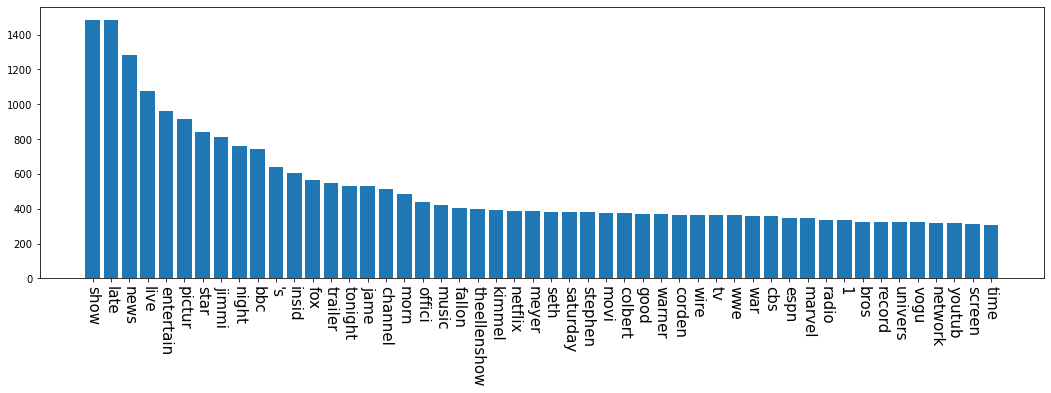

In [50]:
channel_title_nan_count = 0
if os.path.exists("channel_title_words.csv"):
    words = pd.read_csv("channel_title_words.csv")
    words = words["words"].to_frame()
    with open("tokenized_channel_titles.json", "r") as file:
        tokenized_channel_titles = json.load(file)
        file.close()
    for i in tqdm(tokenized_channel_titles):
        if not i:
            channel_title_nan_count += 1
else:
    words = pd.DataFrame()
    tokenized_channel_titles = []
    for i in tqdm(range(len(videos))):
        text = videos["channel_title"].iloc[i]
        if isinstance(text, str):
            tokens = Tokenizer.tokenize(text)
            tokenized_channel_titles.append(tokens)
            words = words.append(pd.DataFrame(data={"words": Tokenizer.tokenize(videos["channel_title"].iloc[i])}), ignore_index=True)
        elif isinstance(text, float):
            if math.isnan(text):
                channel_title_nan_count += 1
                tokenized_channel_titles.append([])
        else:
            print(text, type(text))
            tokenized_channel_titles.append([])
    words.to_csv("channel_title_words.csv")
    with open("tokenized_channel_titles.json", "w") as file:
        json.dump(tokenized_channel_titles, file)
        file.close()
print(len(tokenized_channel_titles))
print(f"Nan: {channel_title_nan_count}")
words_counts = words.value_counts()
words_counts = words_counts.rename_axis("words").reset_index(name="count")
print(words_counts)
wh = words_counts.head(50)
plt.subplots(figsize=(18,5))
plt.bar(wh["words"], wh["count"])
plt.xticks(rotation=270, fontsize=15)
plt.show()

Dodatkowo dla tytułów kanałów zostały przeanalizowane najczęstrze słowa występujące
w tytułach. Na wykresie zostało przedstawione 50 najczęściej występujących
wyrazów, które zostały uzyskane przez poddanie nazw kanałów procesom tokenizacji i
steaming'u. Najczęściej występującymi słowami są **show**, **live**, **news**.

### Identyfikatory filmów - *video_id*

Kolejnym atrybutem tekstowym, który został poddany analizie to *video_id*,
czyli identyfikator filmów.

             count
count  8511.000000
mean      9.383739
std      11.580377
min       1.000000
25%       4.000000
50%       7.000000
75%      12.000000
max     727.000000
         video_id  count
0         #NAZWA?    727
1     8h--kFui1JA     66
2     vjSohj-Iclc     62
3     l884wKofd54     61
4     VYOjWnS4cMY     61
...           ...    ...
8506  2GrKY7Qqal8      1
8507  7DLKv39MLbg      1
8508  W86cTIoMv2U      1
8509  KtA3Wp8eNgA      1
8510  IEqj7xR9iOU      1

[8511 rows x 2 columns]


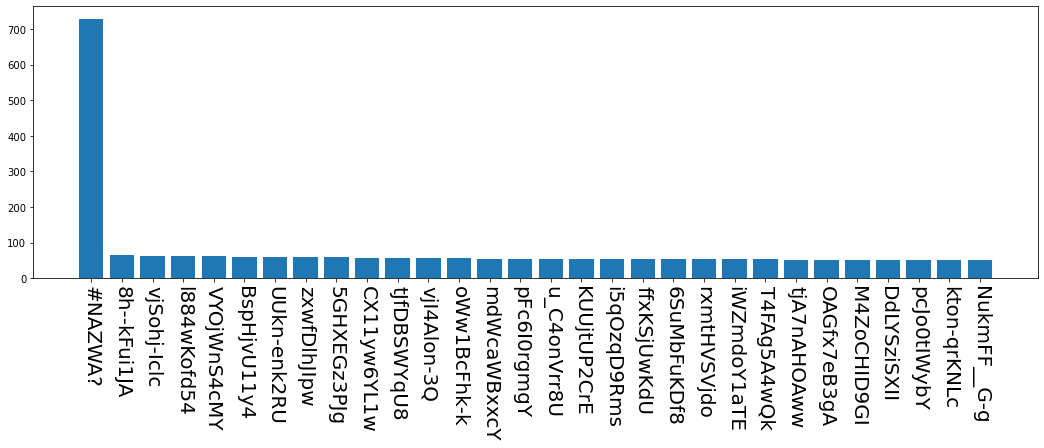

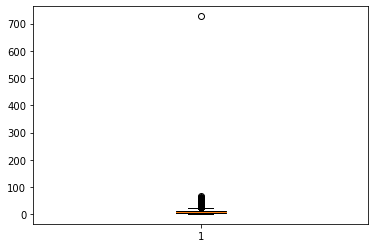

In [51]:
video_counts = videos["video_id"].value_counts()
video_counts = video_counts.rename_axis("video_id").reset_index(name="count")

print(video_counts.describe())

plt.subplots(figsize=(18,5))
plt.bar(video_counts.head(30)["video_id"], video_counts.head(30)["count"])
plt.xticks(rotation=270, fontsize=20)
plt.show()


print(video_counts)
plt.boxplot(video_counts["count"])
plt.show()

Na wykresie kolumnowym można zauważyć, że brakuje aż 727 identyfikatorów
filmów. Dodatkowo można zauważyć, że występuje dużo powtórzeń na innych
wartościach video_id (nawet mediana jest większa niż 1, wynosi 7).

### Tytuły filmów - *title*

Następny tekstowy atrybut występujący w danych to tytuł filmu podobnie jak
dla poprzednich najpierw szukamy powtórzeń i przedstawiamy ich rozkład.

In [52]:
title_counts = videos["title"].value_counts()
title_counts = title_counts.rename_axis("title").reset_index(name="count")

print(title_counts)

title_counts.describe()

                                                  title  count
0           Sam Smith - Pray (Official Video) ft. Logic     66
1                              Getting some air, Atlas?     62
2     Childish Gambino - This Is America (Official V...     61
3     Enrique Iglesias - MOVE TO MIAMI (Official Vid...     61
4     Kelly Clarkson - Meaning of Life [Official Video]     60
...                                                 ...    ...
8787  Charles Barkley on Mean Tweets, Eagles Win, La...      1
8788            International Dunkin' Donuts Taste Test      1
8789   John Mayer On Andy Cohen’s Annoying Habit | WWHL      1
8790      Markelle Fultz Makes His Return To The Court!      1
8791  Ann Curry says verbal sexual harassment was pe...      1

[8792 rows x 2 columns]


,count
count,8792.000000
mean,9.083826
std,8.497842
min,1.000000
25%,3.000000
50%,7.000000
75%,12.000000
max,66.000000


C:\ProgramData\Anaconda3\envs\PED\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 12300 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\envs\PED\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 12301 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\envs\PED\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 12300 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\ProgramData\Anaconda3\envs\PED\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 12301 missing from current font.
  font.set_text(s, 0, flags=flags)


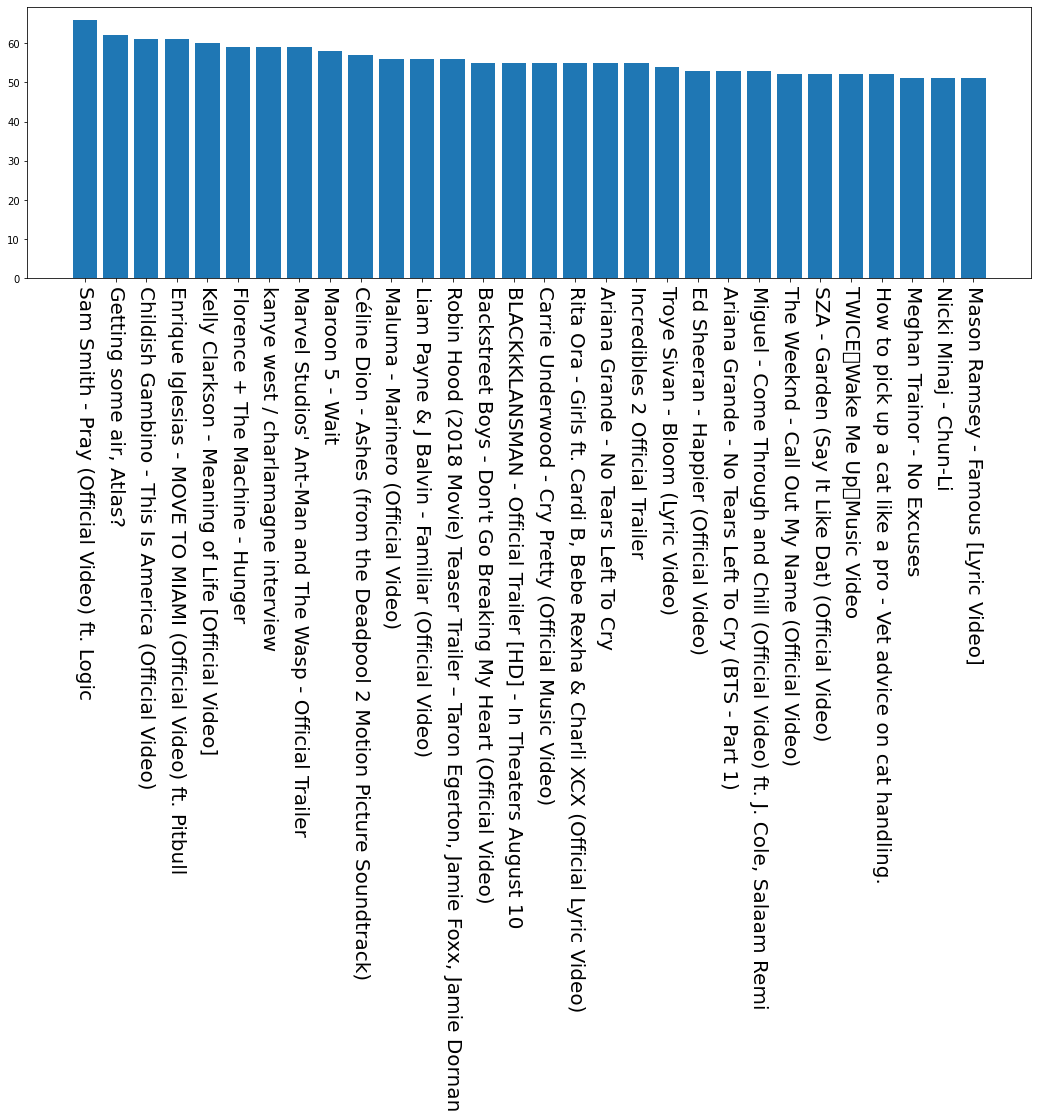

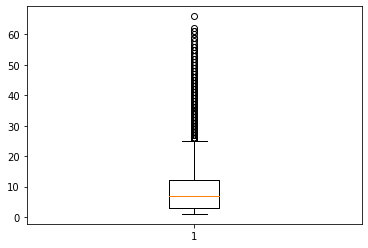

In [53]:
plt.subplots(figsize=(18,5))
plt.bar(title_counts.head(30)["title"], title_counts.head(30)["count"])
plt.xticks(rotation=270, fontsize=20)
plt.show()

plt.boxplot(title_counts["count"])
plt.show()

Podobnie jak w poprzednich atrybutach także w tytułach występują
powtórzenia. Najczęściej powtarzającymi się tytuły piosenek, a
dokładniej teledysków piosenek.

  0%|          | 0/79865 [00:00<?, ?it/s]

79865
Nan: 136
           words  count
0         offici  11028
1          video   8872
2        trailer   5013
3           2018   4458
4             ft   3819
...          ...    ...
10513        fka      1
10514   timeless      1
10515       feig      1
10516  timrollin      1
10517   kasparov      1

[10518 rows x 2 columns]


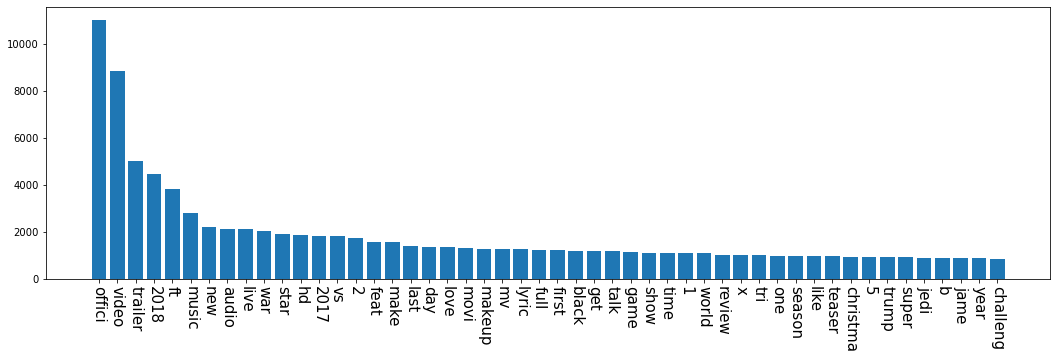

In [54]:
title_nan_count = 0
if os.path.exists("title_words.csv"):
    words = pd.read_csv("title_words.csv")
    words = words["words"].to_frame()
    with open("tokenized_titles.json", "r") as file:
        tokenized_titles = json.load(file)
        file.close()
    for i in tqdm(tokenized_titles):
        if not i:
            title_nan_count += 1
else:
    words = pd.DataFrame()
    tokenized_titles = []
    for i in tqdm(range(len(videos))):
        text = videos["title"].iloc[i]
        if isinstance(text, str):
            tokens = Tokenizer.tokenize(text)
            tokenized_titles.append(tokens)
            words = words.append(pd.DataFrame(data={"words": Tokenizer.tokenize(videos["title"].iloc[i])}), ignore_index=True)
        elif isinstance(text, float):
            if math.isnan(text):
                title_nan_count += 1
                tokenized_titles.append([])
        else:
            print(text, type(text))
            tokenized_titles.append([])
    words.to_csv("title_words.csv")
    with open("tokenized_titles.json", "w") as file:
        json.dump(tokenized_titles, file)
        file.close()
print(len(tokenized_titles))
print(f"Nan: {title_nan_count}")
words_counts = words.value_counts()
words_counts = words_counts.rename_axis("words").reset_index(name="count")
print(words_counts)
wh = words_counts.head(50)
plt.subplots(figsize=(18,5))
plt.bar(wh["words"], wh["count"])
plt.xticks(rotation=270, fontsize=15)
plt.show()

Podobnie jak nazwy kanałów, tytuły filmów zostały także poddane
tokenizacji i steaming'u, w celu przeanalizowania częstotliwości
występowania słów w tytułach. Na wykresie można zobaczyć 50 najczęściej
występujących słów występujących w tytułach filmów. Tutaj można zauważyć, że 
dwoma najczęściej występującymi słowami są **offici** i **video**, co wskazuje
że częśto występowały teledyski piosenek. Kolejny token, który się często
pojawia to **trailer**, który wskazywałby na występowanie zwiastunów
filmów. Występują także tokeny **music**, **feat**, które także wskazują na
piosenki. 

## Linki do obrazów - *thumbnail link*

Kolejny atrybut występujący w formie tekstowej to link do
Linki do obrazów - także są powtórzenia, nie ma braków

In [55]:
thumbnail_counts = videos["thumbnail_link"].value_counts()
thumbnail_counts = thumbnail_counts.rename_axis("thumbnail_link").reset_index(name="count")

print(thumbnail_counts)
thumbnail_counts.describe()

                                      thumbnail_link  count
0     https://i.ytimg.com/vi/8h--kFui1JA/default.jpg     66
1     https://i.ytimg.com/vi/vjSohj-Iclc/default.jpg     62
2     https://i.ytimg.com/vi/l884wKofd54/default.jpg     61
3     https://i.ytimg.com/vi/VYOjWnS4cMY/default.jpg     61
4     https://i.ytimg.com/vi/BspHjvU11y4/default.jpg     60
...                                              ...    ...
8603  https://i.ytimg.com/vi/_BVAJ3PXZ1k/default.jpg      1
8604  https://i.ytimg.com/vi/ryqZUqgjvW8/default.jpg      1
8605  https://i.ytimg.com/vi/q-giH_ezRTE/default.jpg      1
8606  https://i.ytimg.com/vi/JuP1Z8xpRb8/default.jpg      1
8607  https://i.ytimg.com/vi/lyqww9P7qyw/default.jpg      1

[8608 rows x 2 columns]


,count
count,8608.000000
mean,9.277997
std,8.563351
min,1.000000
25%,4.000000
50%,7.000000
75%,12.000000
max,66.000000


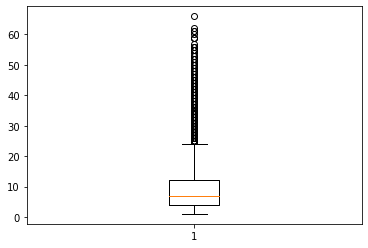

In [56]:
plt.boxplot(thumbnail_counts["count"])
plt.show()

Podobnie jak dla innych atrybutów występują powtórzenia, jendak jest ich znacznie
mniej.


### Opisy filmów - *description*

Kolejny analizowany atrybut to dodany do filmu opis. Tak samo jak dla tytułów
filmów i kanałów została przeprowadzona analiza częstotliwości występowania
opisów, a następnie analiza częstotliwości występowania poszczególnych
wyrazów w opisach.


mamy także powtórzenia nawet na opisach filmów

sprawdzić ilość 'nan' description

In [57]:
description_counts = videos["description"].value_counts()
description_counts = description_counts.rename_axis("description").reset_index(name="count")

description_counts.describe()

,count
count,10391.000000
mean,7.572226
std,7.034861
min,1.000000
25%,3.000000
50%,6.000000
75%,10.000000
max,135.000000


                                             description  count
0      ► Listen LIVE: http://power1051fm.com/\n► Face...    135
1      Every Friday on TMZ Sports UFC Welterweight Ch...     78
2                                        The White House     76
3      SZA's CTRL available on:Apple Music - http://s...     68
4      Stream, Download and Listen to Pray feat. Logi...     62
...                                                  ...    ...
10386  'Wonder Wheel' star Justin Timberlake has his ...      1
10387  The way I see it, I'm 3 months ahead of schedu...      1
10388  Cardi B - Drip feat. Migos available now!\nStr...      1
10389  https://www.buzzfeed.com/marietelling/how-to-c...      1
10390                                       Sterling, VA      1

[10391 rows x 2 columns]


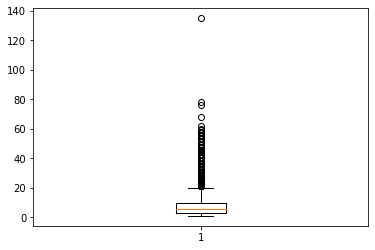

In [58]:
print(description_counts)
plt.boxplot(description_counts["count"])
plt.show()

Ciekawą obserwacją są powtórzenia nawet na poziomie opisów filmów. Widać, że
jeden z opisów powtórzył się aż 135 razy.

  0%|          | 0/79865 [00:00<?, ?it/s]

79865
Nan: 1221
                                                words
0                                               click
1                                             continu
2                                               stori
3                                                make
4                                             monster
...                                               ...
6289905                 http://twitter.com/callofduti
6289906        http://twitter.com/treyarch;instagram:
6289907               http://instagram.com/callofduti
6289908  http://www.instagram.com/treyarch/;snapchat:
6289909                                    callofduti

[6289910 rows x 1 columns]
                             words  count
0                            video  62293
1                           follow  43757
2                            music  42892
3                          twitter  40545
4                         subscrib  36635
...                            ...    ...
76540         

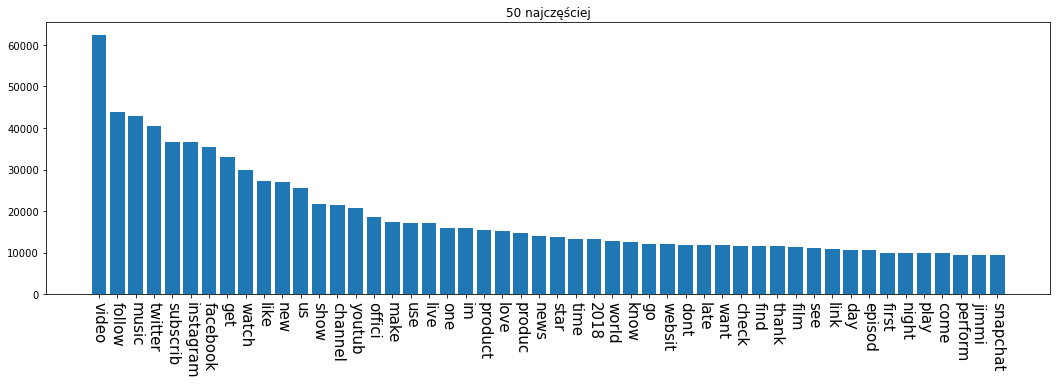

In [59]:
description_nan_count = 0
if os.path.exists("description_words.csv"):
    words = pd.read_csv("description_words.csv")
    words = words["words"].to_frame()
    with open("tokenized_descriptions.json", "r") as file:
        tokenized_descriptions = json.load(file)
        file.close()
    for i in tqdm(tokenized_descriptions):
        if not i:
            description_nan_count += 1
else:
    words = pd.DataFrame()
    tokenized_descriptions = []
    for i in tqdm(range(len(videos))):
        text = videos["description"].iloc[i]
        if isinstance(text, str):
            tokens = Tokenizer.tokenize(text)
            tokenized_descriptions.append(tokens)
            words = words.append(pd.DataFrame(data={"words": Tokenizer.tokenize(videos["description"].iloc[i])}), ignore_index=True)
        elif isinstance(text, float):
            if math.isnan(text):
                description_nan_count += 1
                tokenized_descriptions.append([])
        else:
            print(text, type(text))
            tokenized_descriptions.append([])
    words.to_csv("description_words.csv")
    with open("tokenized_descriptions.json", "w") as file:
        json.dump(tokenized_descriptions, file)
        file.close()
    split_csv("description_words.csv")
print(len(tokenized_descriptions))
print(f"Nan: {description_nan_count}")
print(words)
words_counts = words.value_counts()
words_counts = words_counts.rename_axis("words").reset_index(name="count")
print(words_counts)
wh = words_counts.head(50)
plt.subplots(figsize=(18,5))
plt.bar(wh["words"], wh["count"])
plt.title("50 najczęściej")
plt.xticks(rotation=270, fontsize=15)
plt.show()

Analiza najczęściej występujących tokenów podobnie potwierdza, że
często występują piosenki. Jak we wcześniejszych atrybutach występują
tokeny **video**, **music**. Dodatkowo można zobaczyć, że także
często pojawiają się nazwy portali społecznościowych. Także często występują
słowa mające na celu zachęcenie do aktywności na kanale lub innym medium społecznościowym,
czyli tokeny **subscrib**, **follow**, **like**.

Dodatkowo w opisach występuje wiele linków, dlatego dla tego atrybutu
dodatkowo zostały wyekstrachowane linki z opisów, a następnie z nich
nazwy domenowe serwerów.

               domain
0              bit.ly
1              bit.ly
2        elbow.lnk.to
3              bit.ly
4        facebook.com
...               ...
557663   facebook.com
557664    twitter.com
557665    twitter.com
557666  instagram.com
557667  instagram.com

[557668 rows x 1 columns]
                    domain  count
0                   bit.ly  86211
1              youtube.com  55516
2              twitter.com  50304
3            instagram.com  46838
4             facebook.com  42199
...                    ...    ...
3970      med.stanford.edu      1
3971     tovestyrke.lnk.to      1
3972      loveniplaw.co.uk      1
3973        shangri-la.com      1
3974  portugalstore.fpf.pt      1

[3975 rows x 2 columns]


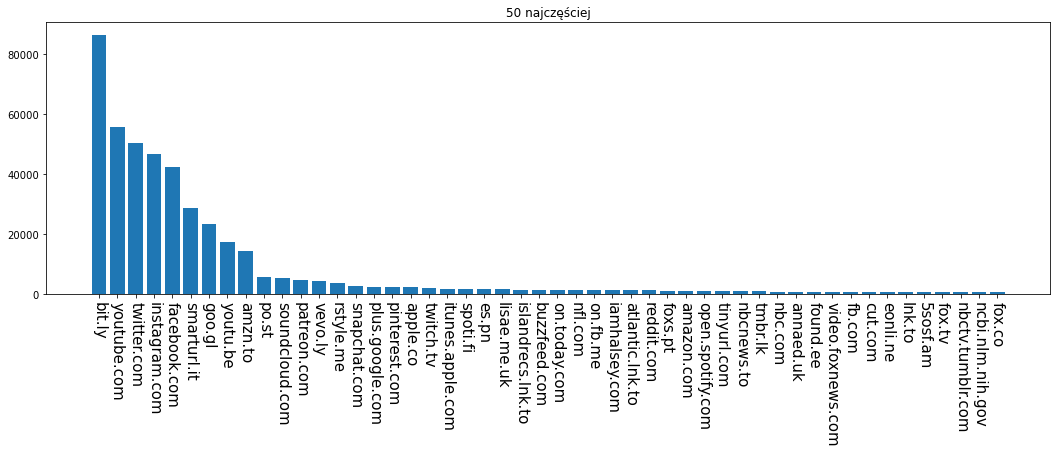

In [60]:
if os.path.exists("domains.csv"):
    domains = pd.read_csv("domains.csv", index_col=0)
    with open("domains.json", "r") as file:
        all_domains_data = json.load(file)
        file.close()
else:
    domains = pd.DataFrame()
    all_domains_data = []
    for tokens in tqdm(tokenized_descriptions):
        domains_list = []
        for token in tokens:
            if re.match(RE_HTTP, token):
                f = token.index("://")
                link = token[f + 3:]
                if "/" in link:
                    l = link.index("/")
                    domain = link[:l]
                else:
                    domain = link
                domain = domain.replace("www.", "")
                domains_list.append(domain)
        all_domains_data.append(domains_list)
        domains = domains.append(pd.DataFrame(data={"domain": domains_list}), ignore_index=True)
    domains.to_csv("domains.csv")
    with open("domains.json", "w") as file:
        json.dump(all_domains_data, file)
        file.close()
print(domains)
domains_counts = domains.value_counts()
domains_counts = domains_counts.rename_axis("domain").reset_index(name="count")
print(domains_counts)
dh = domains_counts.head(50)
plt.subplots(figsize=(18,5))
plt.bar(dh["domain"], dh["count"])
plt.title("50 najczęściej")
plt.xticks(rotation=270, fontsize=15)
plt.show()

Wśród najczęściej występujących nazw domenowych są takie portale jak
**YouTube**, **Facebook**, **Instagram**, **Twitter**. Może to wskazywać, że dodatkowo
oprócz kanału na portalu YouTube, często powstają konta dla fanów na
innych portalach społecznościowych.

### Tagi przy filmach - *tags*

Następny atrybut tekstowy występujący w danych to tagi umieszczone przy filmach.
Wymagają one jednak wstępnego przygotowania, a mianowicie podzielenia ich wg znaku
*'|'*. Tutaj została przeprowadzona analiza częstotliwości.

warto zwrócić uwagę, że już 3 miejsce pod względem liczności to filmy bez tagów !!

In [61]:
videos["tags"] = videos["tags"].str.replace('"', "")
tags = videos["tags"].str.split("|").apply(pd.Series, 1).stack()
tags.index = tags.index.droplevel(-1)
tags.name = "tags"
tags = tags.to_frame()
unique_tags = tags["tags"].value_counts() #
unique_tags = unique_tags.rename_axis("tag").reset_index(name="count")
unique_tags.describe()

,count
count,72467.000000
mean,20.818055
std,67.668262
min,1.000000
25%,5.000000
50%,9.000000
75%,18.000000
max,6232.000000


                tag  count
0             funny   6232
1            comedy   5253
2            [none]   3545
3             music   3274
4               Pop   2836
...             ...    ...
72462        Quinta      1
72463  tax loophole      1
72464   Female Role      1
72465         Wrote      1
72466   kick return      1

[72467 rows x 2 columns]


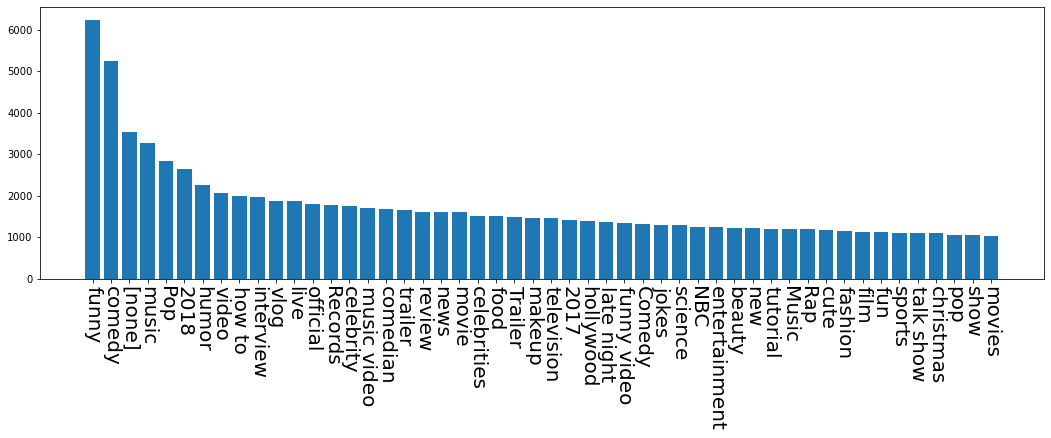

In [62]:
print(unique_tags)
plt.subplots(figsize=(18,5))
plt.bar(unique_tags.head(50)["tag"], unique_tags.head(50)["count"])
plt.xticks(rotation=270, fontsize=20)
plt.show()


Podobnie jak dla innych atrybutów w najczęśniej występujących tagach występują
wyrarzenia wskazujące na muzykę (**music**, **pop**). Dodatkowo
występują słowa wskazujące na komedie oraz na prowadzenie autycji na żywo.
Także występują słowa wskazujące na zwiastuny filmów (**movie**, **trailer*).

## Atrybuty nietekstowe

W danych występują także atrybuty, które nie są typu tekstowego. Dla nich także
została przeprowadzona wstępna analiza.


### Atrybuty logiczne

Pierwszym z rodzajem atrybutów, który został poddany analizie to
atrybut logiczny (ang. *bool*). W danych występują trzy kolumny o takim
typie:
- **comments_disabled**,
- **ratings_diabled**,
- **video_error_or_removed**.

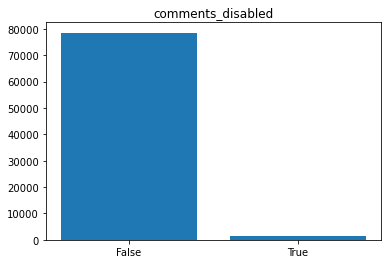

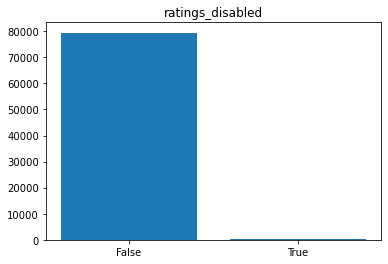

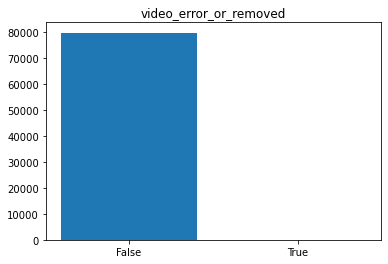

In [63]:
bool_attrs = ["comments_disabled", "ratings_disabled", "video_error_or_removed"]
for attr in bool_attrs:
    attr_c = videos[attr].value_counts()
    attr_c = attr_c.rename_axis(attr).reset_index(name="count")
    plt.title(attr)
    plt.bar(["False", "True"], attr_c["count"])
    plt.show()

Można zauważyć znaczną przewagę wartości 'False', co wskazuje, że filmy z
sekcji treniding mają włączone komentarze, włączona jest także możliwość ich oceny,
a także nie zostały usunięte lub błędne.

### Atrybuty liczbowe

Kolejny typ atrybutu, który pojawia się atrybuty liczbowe. W śród
nich występują kolumny:
- **category_id**,
- **views**,
- **likes**,
- **dislikes**,
- **comment_count**

Dodatkowo wygenerowano 3 dodatkowe atrybuty:
- **description_len** - długość opisów,
- **title_len** - długość tytułu,
- **channel_title_len** - długość nazwy kanału.

In [64]:
videos["description_len"] = videos["description"].str.len()
videos["title_len"] = videos["title"].str.len()
videos["channel_title_len"] = videos["channel_title"].str.len()
videos.describe()

,category_id,views,likes,dislikes,comment_count,description_len,title_len,channel_title_len
count,3932.000000,7.986500e+04,7.986500e+04,7.986500e+04,7.986500e+04,78683.000000,79865.000000,79865.000000
mean,18.459563,4.091166e+06,1.036262e+05,5.612328e+03,1.070850e+04,961.199014,49.051612,12.959870
std,7.740292,1.439125e+07,2.957265e+05,4.124462e+04,4.443679e+04,823.965555,19.739152,6.290308
min,1.000000,5.490000e+02,0.000000e+00,0.000000e+00,0.000000e+00,1.000000,3.000000,1.000000
25%,10.000000,2.464170e+05,5.642000e+03,2.010000e+02,6.420000e+02,382.000000,34.000000,9.000000
50%,22.000000,7.961060e+05,2.092200e+04,7.120000e+02,2.099000e+03,732.000000,47.000000,12.000000
75%,24.000000,2.535704e+06,7.824800e+04,2.527000e+03,7.220000e+03,1298.000000,61.000000,16.000000
max,43.000000,4.245389e+08,5.613827e+06,1.944971e+06,1.626501e+06,5260.000000,100.000000,49.000000


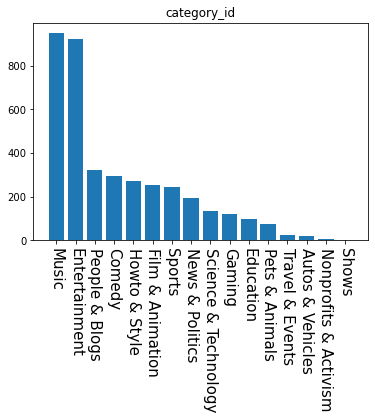

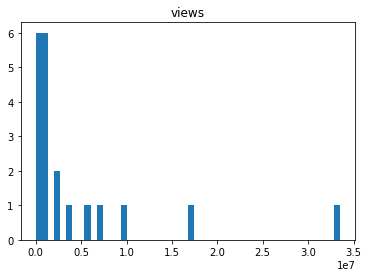

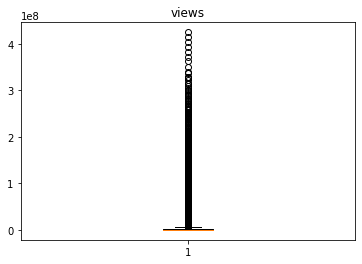

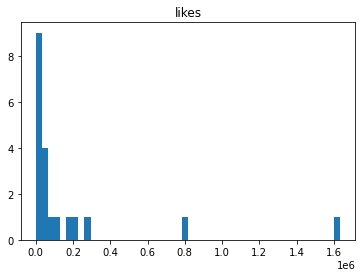

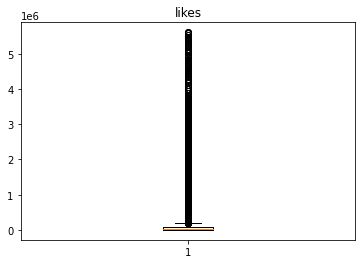

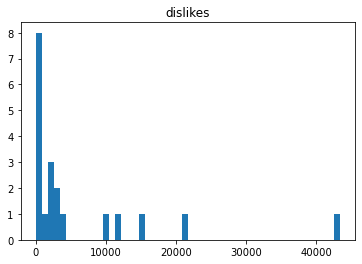

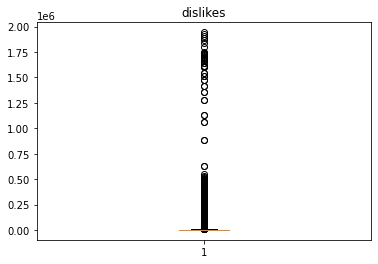

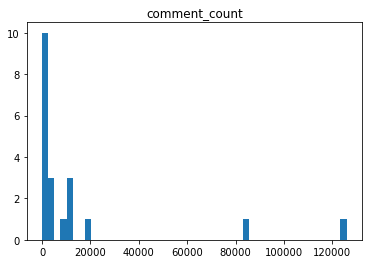

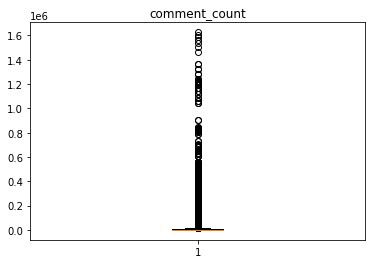

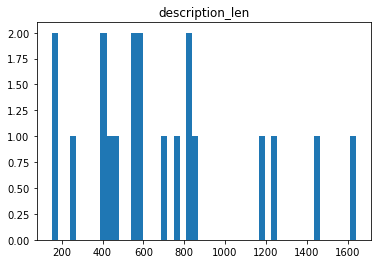

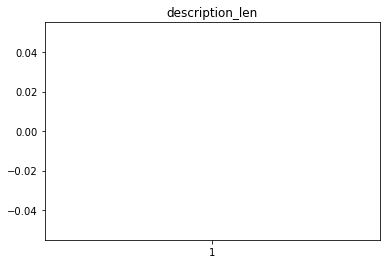

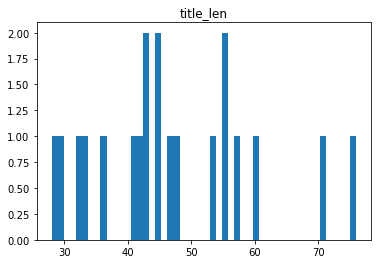

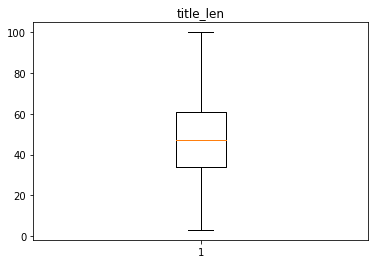

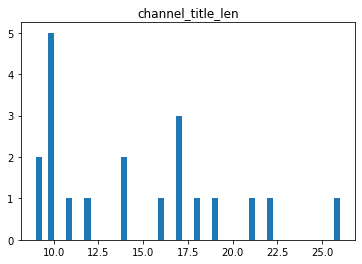

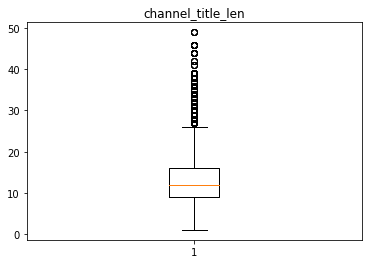

Liczby wartości 'nan'
Atrybut category_id: 75933
Atrybut views: 0
Atrybut likes: 0
Atrybut dislikes: 0
Atrybut comment_count: 0
Atrybut description_len: 1182
Atrybut title_len: 0
Atrybut channel_title_len: 0


In [84]:
numeric_attrs = [
    "category_id", "views", "likes", "dislikes", "comment_count", "description_len", "title_len", "channel_title_len"
]

nan_counts = dict()
categories_dict = get_categories_dict()

for attr in numeric_attrs:
    plt.title(attr)
    nan_counts[attr] = videos[attr].isna().sum()
    if attr !=  "category_id":
        plt.hist(videos[attr].head(20), bins=50)
        plt.show()
        plt.title(attr)
        plt.boxplot(videos[attr])
        plt.show()
    else:
        attr_c = videos[attr].value_counts()
        attr_c = attr_c.rename_axis(attr).reset_index(name="count")
        labels = [categories_dict[i] for i in attr_c[attr]]
        plt.bar(labels, attr_c["count"])
        plt.xticks(rotation=270, fontsize=15)
        plt.show()


print("Liczby wartości 'nan'")
for key in nan_counts.keys():
    print(f"Atrybut {key}: {nan_counts[key]}")

Ciekwaym spostrzerzeniem jest minimum **like**, **dislike** i **comment**
wynoszące 0. Dodatkowo można zauważyć, że film może trafić do trending,
nawet jeśli ma dużą liczbę **dislike**. Podobnie jak dla innych
atrybutów można zauważyć, że kolejny atrybut wskazuje na muzykę, czyli
najczęstrza występująca kategoria to **Music**.

Większość wartości atrybutu **dislike** skupione są w okolicach zera, w przypadku
polubień filmów występuje znacznie większa wyższych wartości, podobnie
wyświetleń filmów. Liczby komentarzy pod filmami poniżej 2 000 jednak występują
także większe liczby dochodzące nawet do 10 tys. komentarzy.

Opisy filmów zazwyczaj nie przekraczają 1500 znaków, a długości tytułów
skupione są przy średniej wynoszącej około 49. średnia długość
nazwy kanału to około 12 znaków.

Na wykresie kategorii pominięto wartości nan, ponieważ jest ich bardzo dużo, co zakłuca
czytelność wykresu. W zbiorze występuje 75933 wartości 'nan' dla atrybutu
**category_id**.

### Atrybuty czasu

Kolejny typ atrybutu pojawaijący się w danych odnosi się do
przebiegu czasu. Wśród nich występują kolumny:
- **trending_date**,
- **published_time**.

In [66]:
trending_date_counts = videos["trending_date"].value_counts()
trending_date_counts = trending_date_counts.rename_axis("trending_date").reset_index(name="count")

trending_date_counts.describe()

,count
count,205.000000
mean,389.585366
std,14.843589
min,347.000000
25%,381.000000
50%,399.000000
75%,400.000000
max,400.000000


    trending_date  count
0        17.09.12    400
1        18.17.01    400
2        18.12.01    400
3        18.23.01    400
4        17.19.12    400
..            ...    ...
200      18.24.05    355
201      18.21.05    354
202      18.23.05    353
203      18.22.05    352
204      18.15.05    347

[205 rows x 2 columns]


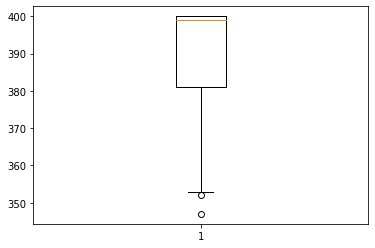

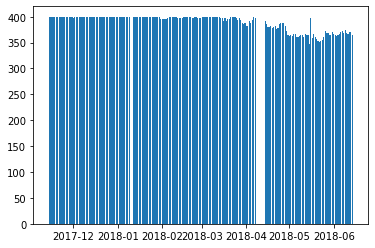

In [67]:
print(trending_date_counts)
plt.boxplot(trending_date_counts["count"])
plt.show()

plt.bar(pd.to_datetime(trending_date_counts["trending_date"], format="%y.%d.%m"), trending_date_counts["count"])
plt.show()

Na wykresie zostały przedstawione liczby filmów, które zostały zaliczone do sekcji
Trending na przestrzeni czasu w poszczególnych dniach. Można zauważyć, że liczby w poszczególnych
dniach są zbliżone do siebie. Na wykresie widoczne są także okresy, w których nie było filmów
uznawanych za filmy trending. 

In [68]:
videos["trending_date_day_of_week"] = pd.to_datetime(videos["trending_date"], format="%y.%d.%m").dt.dayofweek

trending_date_day_of_week_counts = videos["trending_date_day_of_week"].value_counts()
trending_date_day_of_week_counts = trending_date_day_of_week_counts.rename_axis("trending_date_day_of_week").reset_index(name="count")

trending_date_day_of_week_counts.describe()

,trending_date_day_of_week,count
count,7.000000,7.000000
mean,3.000000,11409.285714
std,2.160247,200.039758
min,0.000000,11264.000000
25%,1.500000,11279.500000
50%,3.000000,11321.000000
75%,4.500000,11494.500000
max,6.000000,11732.000000


0        1
1        1
2        1
3        1
4        1
        ..
40944    3
40945    3
40946    3
40947    3
40948    3
Name: trending_date_day_of_week, Length: 79865, dtype: int64


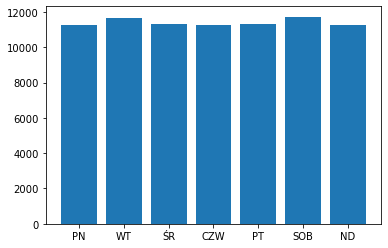

In [82]:
print(videos["trending_date_day_of_week"])


plt.bar(trending_date_day_of_week_counts["trending_date_day_of_week"], trending_date_day_of_week_counts["count"])
plt.xticks([0, 1, 2, 3, 4, 5, 6], ["PN", "WT", "ŚR", "CZW", "PT", "SOB", "ND"])
plt.show()

Wykres przedstawia rozkład liczby filmów w zależności od dnia tygodnia, w którym zostały
dołączone do zakładki Trending. Na wykresie można zauważyć, że liczby filmów w poszczególnych
dniach jest zbliżona.


In [70]:
publish_time_counts = videos["publish_time"].value_counts()
publish_time_counts = publish_time_counts.rename_axis("publish_time").reset_index(name="count")

publish_time_counts.describe()


,count
count,8466.000000
mean,9.433617
std,8.820968
min,1.000000
25%,4.000000
50%,7.000000
75%,12.000000
max,77.000000


                  publish_time  count
0     2018-05-18T14:00:04.000Z     77
1     2018-03-30T04:00:02.000Z     73
2     2018-02-23T05:00:01.000Z     71
3     2018-03-09T05:00:03.000Z     70
4     2018-05-09T17:00:00.000Z     66
...                        ...    ...
8461  2017-12-07T03:10:14.000Z      1
8462  2017-12-19T02:06:23.000Z      1
8463  2018-03-20T13:00:45.000Z      1
8464  2017-11-29T20:00:00.000Z      1
8465  2017-12-01T14:33:36.000Z      1

[8466 rows x 2 columns]


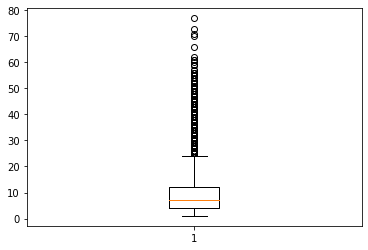

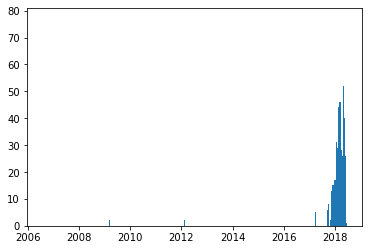

In [71]:
print(publish_time_counts)
plt.boxplot(publish_time_counts["count"])
plt.show()
# 2017-12-25T20:21:57.000Z
plt.bar(pd.to_datetime(publish_time_counts["publish_time"], format="%Y-%m-%dT%H:%M:%S.%fZ"), publish_time_counts["count"])
plt.show()

Na wykresie można zauważyć, że większość filmów pochodzących ze zbioru została opublikowana
na przestrzeni końca 2017 i początku 2018 roku. W zbiorze pojawiają się także pojedyncze spoza tego
okresu.


In [72]:
videos["publish_time_day_of_week"] = pd.to_datetime(videos["publish_time"], format="%Y-%m-%dT%H:%M:%S.%fZ").dt.dayofweek

publish_time_day_of_week_counts = videos["publish_time_day_of_week"].value_counts()
publish_time_day_of_week_counts = publish_time_day_of_week_counts.rename_axis("publish_time_day_of_week").reset_index(name="count")

publish_time_day_of_week_counts.describe()

,publish_time_day_of_week,count
count,7.000000,7.000000
mean,3.000000,11409.285714
std,2.160247,3712.714807
min,0.000000,5795.000000
25%,1.500000,9246.000000
50%,3.000000,12738.000000
75%,4.500000,14102.000000
max,6.000000,14636.000000


0        4
1        6
2        4
3        0
4        0
        ..
40944    4
40945    4
40946    4
40947    3
40948    3
Name: publish_time_day_of_week, Length: 79865, dtype: int64


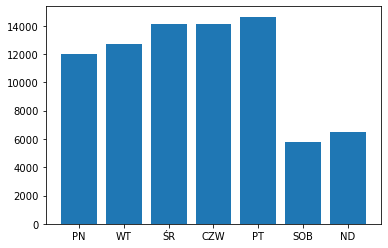

In [81]:
print(videos["publish_time_day_of_week"])


plt.bar(publish_time_day_of_week_counts["publish_time_day_of_week"], publish_time_day_of_week_counts["count"])
plt.xticks([0, 1, 2, 3, 4, 5, 6], ["PN", "WT", "ŚR", "CZW", "PT", "SOB", "ND"])
plt.show()

Wykres przedstawia dni tygodnia ilości publikowanych filmów w zależności
od dnia tygodnia. Na wykresie można zauważyć że najwięcej filmów
publikowanych jest w piątki. Dodatkowo warto zauważyć,
że liczba publikowanych filmów rośnie od poniedziałku do piątku,
a na weekend drastycznie spada. Być może
filmy udostępnione tuż przed weekendem
mają większe szanse na dostanie się do sekcji
trending.


In [76]:
videos["publish_time_hour_of_day"] = pd.to_datetime(videos["publish_time"], format="%Y-%m-%dT%H:%M:%S.%fZ").dt.hour

publish_time_hour_of_day_counts = videos["publish_time_hour_of_day"].value_counts()
publish_time_hour_of_day_counts = publish_time_hour_of_day_counts.rename_axis("publish_time_hour_of_day").reset_index(name="count")

publish_time_hour_of_day_counts.describe()

,publish_time_hour_of_day,count
count,24.000000,24.000000
mean,11.500000,3327.708333
std,7.071068,1739.710308
min,0.000000,1149.000000
25%,5.750000,1962.500000
50%,11.500000,2988.000000
75%,17.250000,4100.750000
max,23.000000,6900.000000


0         7
1         6
2        17
3         2
4         1
         ..
40944    13
40945     1
40946    17
40947    17
40948    17
Name: publish_time_hour_of_day, Length: 79865, dtype: int64


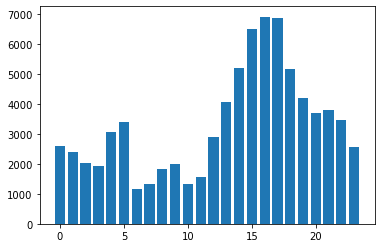

In [77]:
print(videos["publish_time_hour_of_day"])


plt.bar(publish_time_hour_of_day_counts["publish_time_hour_of_day"], publish_time_hour_of_day_counts["count"])
plt.show()


Na wykresie można zauważyć, że większość filmów dodawana jest po południu, czyli
między godzinami 15 i 20.

## Podsumowanie

Pierwszy atrybut pojawiający się w zbiorze (**video_id**) niestety nie może zostać użyty
do oceny, czy film dostanie się do sekcji trending. Mimo że pozwala on identyfikować
filmy, to nie wnosi on żadnej informacji na temat filmu.

Następny atrybut, **trending_date**, podobnie jak **video_id**, prawdopodobnie nie będzie
dobrym atrybutem pozwalającym na przewidzenie szans na sklasyfikowanie filmu jako Trending.
Atrybut ten wskazuje na czas pojawienia się w owej sekcji, ciężko było by wnioskować na jego
podstawie.

Kolejny atrybut, **title**, może wnieść informację czy dany film trafi do sekcji Trending,
umieszczenie w nim słów kluczownych może zachęcić użytkownika do oglądnięcia filmu,
co może przełożyć się na szanse dostania się sekcji Trending.

Podobnie jak w przypadku tytułu filmu także, atrybut **channel_title** może mieć wpływ na
zakwalifikowanie się do sekcji trending. Tutaj także w danych można zauważyć, że
występują w nich słowa kluczowe, które mogą wpłynąć na prawdopodobieństwo zostania
filmem trending.

Kolejny atrybut **category_id** prawdopodobnie może mieć wpływ na dostanie się do sekcji
trending. Jednak jest w nim aktualnie zbyt dużo wartości brakujących, aby wnioskować
na podstawie niego. Analizę należałoby powtórzyć podczas realizacji etap 4 tego zadania.

Atrybut **publish_time** może mieć wpływ na możliwość dostania się do sekcji Trending.
Prawdopodobnie nie będzie on brany pod uwagę w postaci pełnej daty, ale
zamiana tego atrybutu np. na zaproponowany wyżej dzień tygodnia może
wnieść informację. Można zauważyć, że występuje trochę więcej filmów publikowanych
bliżej weekendu.

Podobnie jak tytuły kanału i filmu, atrybut **tags** po wykonaniu wstępnego
przetwarzania może przynieść informacji na temat tego, czy film trafi do
sekcji Trending. Tutaj także osoba publikująca film może użyć kluczowych słów,
które podniosą prawdopodobieństwo pojawiania się w sekcji Trending.

Występujące w zbiorze danych atrybuty liczbowe (**views**, **likes**, **dislikes**, **comment_count**)
będą dobrymi atrybutami do wnioskowania na temat szans do pojawiania się w sekcji Trending.

Atrybut de facto tekstowy **thumbnail_link** w postaci tekstowej nie wniesie żadnej
informacji na temat filmu i nie powinien być brany pod uwagę w przewidywaniu
prawdopodobieństwa ukazania się w sekcji Trending. Jednak pobrane
na ich podstawie obrazy już mogą wnieść dodatkowej wiedzy do rozpatrywanego
problemu, co okaże się w drugim etapie zadania.

Zmienne logiczne pojawiające się w zbiorze (**comments_disabled**, **ratings_disabled**,
**video_error_or_removed**) mogą wnieść dość dużo wiedzy, ponieważ widać
w zbiorze przewagę wartości *prawda*. Jeśli w etapie 5 okaże się, że
w filmach niebędących trending pojawią się wartości *fałsz*, będą to dobrze
dyskryminujące atrybuty.

Ostatni występujący w zbiorze atrybut **description** jak atrybuty tytuł filmy, kanału i
tagi także mogą być atrybutem, który dostarczy cennych informacji na temat filmu.
Dodatkowo z niego uzyskać informację na temat linków do innych stron, co także może
pozwolić rozróżnić filmy, które nadają się do sekcji Trending.